## Chapter 4. Training Models

Notes taken from [here](https://www.safaribooksonline.com/library/view/hands-on-machine-learning/9781491962282/ch04.html).

Original notebook available [here](https://github.com/ageron/handson-ml/blob/master/04_training_linear_models.ipynb).

---

In [2]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = [10, 5]

This chapter will explore exactly how a few of the models we've looked at work in detail. We'll look at *Linear Regression Model*, with two ways to train it: *Direct, closed-form equation*, and *Gradient Descent*. We'll look at a few versions of GD that will appear again when looking at neural networks later.

We'll also look at *polynominal regression*, which can fit non-linear datasets. It is prone to overfitting, so we'll explore how to reduce the risk of overfitting via regularization.

Finally, we'll look at two models commonly used for classification: *Logistic Regression* and *Softmax Regression*.

### Linear Regression

A linear model makes a prediction simply by using a weighted sum of input features, plus a bias, or interecept. 

$
\hat{y} = h_{\boldsymbol{\theta}}(\mathbf{x}) = \boldsymbol{\theta} \cdot \mathbf{x}
$

So how do we train it? We need to find a value of $ \boldsymbol\theta $ that minimizes the error.

#### The Normal Equation

There is a mathematical formula that gives the solution directly, called *The Normal Equation*.

$
\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$

let's test it out!

here's some linear-ish data to test our equation on:

In [3]:
import numpy as np

# 100 samples, between 0 and 2
X = 2 * np.random.rand(100, 1)
# our function, Y = 4 + 3x + random noise (gaussian)
y = 4 + 3 * X + np.random.randn(100, 1)

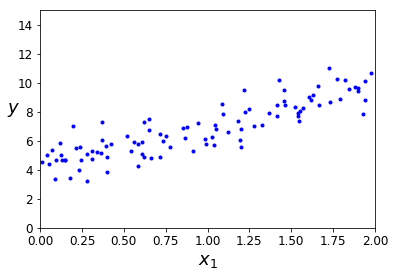

In [4]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

cool. now let's try computing $ \boldsymbol\theta $. We can use `inv` for inverse of a matrix and `dot` for dotproduct.

In [5]:
X_b = np.c_[np.ones((100, 1)), X]  # add x0 = 1 to each instance
# not really sure why to add x0= 1..
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[ 4.21509616],
       [ 2.77011339]])

The actual equation was `Y = 3X + 4`, but 2.7 and 4.3 are pretty close. Now we can make predictions using $ \hat{\boldsymbol\theta} $

In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
# predict values for X=0 and X=2, then we can plot that line
y_predict

array([[ 4.21509616],
       [ 9.75532293]])

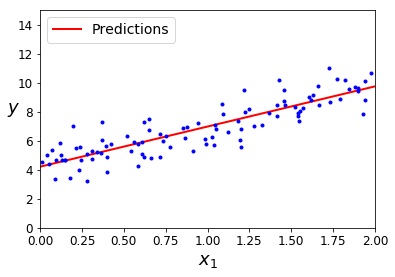

In [6]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show()

Rather than implement this ourselves, we could have used scikit learn's linearregression model. It doesn't do it the way we have above though..

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 4.21509616]), array([[ 2.77011339]]))

#### Gradient Descent

*Gradient Descent* is a generic algorithmic approach where we tweak parameters iteratively to try and minimize a cost function. With it, we measure the local gradient of the error function with respect to $ \boldsymbol\theta $ and move in the direction of decreasing gradient.

An important parameter of the search is *learning rate*. If it is too small, we take baby steps and may take a long time to arrive at the minimum. If it is too big, we may jump around and actually move away from the minimum.

There is also the problem that the error function may not be shaped like a bowl; in which case there may be many local minimum. If we find one of them and stop, we will have missed out on the global minimum.

The MSE function of a linear regression model is convex and continous. This means that gradient descent will always converge close to global minimum as long as learning rate isn't too high.

It is important to ensure that the scale of all of the model's parameters have been standardized, otherwise it may take a long time to arrive at the minimum.

In order to compute the gradient of the function with regards to each parameter, $ \theta_j $, you need to calculate how much the function will change if you change $ \theta_j $ just a little bit, ie the partial derivative of the cost function with respect to $ \theta_j $, ie. $\frac{\partial}{\partial \theta_j} \text{MSE}(\boldsymbol{\theta})$.

This is how you do it!


$
\dfrac{\partial}{\partial \theta_j} \text{MSE}(\boldsymbol{\theta}) = \dfrac{2}{m}\sum\limits_{i=1}^{m}(\boldsymbol{\theta}^T \mathbf{x}^{(i)} - y^{(i)})\, x_j^{(i)}
$

Instead of computing the partial for each parameter individually, we can compute them all at once:


$
\nabla_{\boldsymbol{\theta}}\, \text{MSE}(\boldsymbol{\theta}) =
\begin{pmatrix}
 \frac{\partial}{\partial \theta_0} \text{MSE}(\boldsymbol{\theta}) \\
 \frac{\partial}{\partial \theta_1} \text{MSE}(\boldsymbol{\theta}) \\
 \vdots \\
 \frac{\partial}{\partial \theta_n} \text{MSE}(\boldsymbol{\theta})
\end{pmatrix}
 = \dfrac{2}{m} \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$



$ \nabla_{\boldsymbol{\theta}}\, \text{MSE}(\boldsymbol{\theta}) $ is the *gradient vector* and contains all the partial derivatives of the cost function (one for each model parameter). 

Notice that the above equation requires the full training set, $ \mathbf{X} $, at each step. So, it can be very slow with large training sets. It does scale well with the # of features though..

Once you have the gradient vector (pointing uphill, ie. how is the error function increasing), we just subtract that, times the learning rate from $ \theta $ to get the downhill step, ie: 
$
\boldsymbol{\theta}^{(\text{next step})} = \boldsymbol{\theta} - \eta \nabla_{\boldsymbol{\theta}}\, \text{MSE}(\boldsymbol{\theta})
$.


Let's implement it!

In [8]:
# learning rate
eta = 0.1

# steps
n_iterations = 1000

# num. of samples
m = len(X_b)

# a 'random' starting point
theta = np.random.randn(2,1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    
theta

array([[ 4.21509616],
       [ 2.77011339]])

same result as the normal equation, great! How would this have differed with different learning rates?

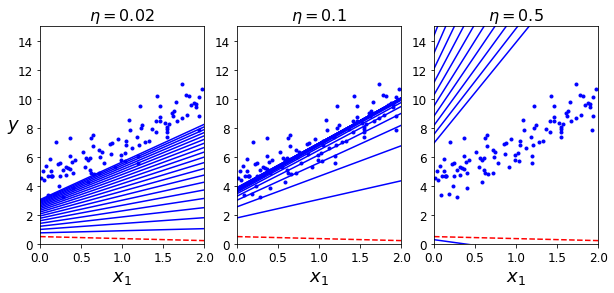

In [9]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 20
    for iteration in range(n_iterations):
        if iteration < 30:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)
    
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

(limiting render to first 30 iterations). The plot on the left has too low a learning rate, it will take forever to converge. The one on the right is too high; it just diverges. The middle one is pretty good!

How to set # of iterations? A simple solution is to set that #high, but break the loop when the changes in gradient becomes smaller than some tolerance, $ \epsilon $.

#### Stochastic Gradient Descent

The main problem with *Batch Gradient Descent* is that it uses the whole training set every step, which can be very slow. A very different approach is *Stochastic Gradient Descent*, which picks a single random instance at every step. This makes it very fast, and can even run out of core.

Due to it's randomness, it will never settle down at the absolute minimum, but instead will jump around. However, the randomness is good for getting out of local minima; ie, it may 'bounce' out and into another nearby downwar slope.

One solution to have Stochastic settle down near the absolute minimum is to reduce the learning rate over time. The function that determines the learning rate at each step is called the *learning schedule*. 

Here's some code that implements stochastic with a simple learning schedule:

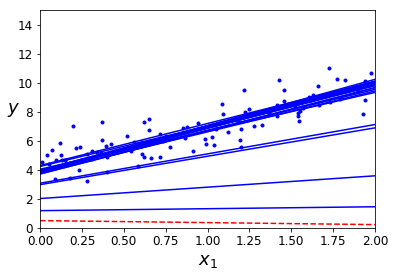

In [10]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 

plt.plot(X, y, "b.")                                 
plt.xlabel("$x_1$", fontsize=18)                     
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                              
plt.show()                                           

In [11]:
theta

array([[ 4.21076011],
       [ 2.74856079]])

This approach went through the training set 50 times and got a pretty good result! You can see how it hops around pretty quickly to get near the minimum.

To do something quite similar using sci-kit learn you can use *SGDRegressor*

In [12]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(n_iter=50, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=50, penalty=None, power_t=0.25,
       random_state=42, shuffle=True, verbose=0, warm_start=False)

In [13]:
sgd_reg.intercept_, sgd_reg.coef_

(array([ 4.16782089]), array([ 2.72603052]))

Again, a very simliar solution to all of the approaches we've seen.

#### Mini-Batch Gradient Descent

Instead of using the full set like regular Gradient Descent, or single instances, like Stochastic, it uses random sub-samples of the training set. One advantage of this approach is that it can take advantage of matrix operations available on GPUs.

The following shows a mini-batch implementation:

In [14]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [15]:
theta

array([[ 4.25214635],
       [ 2.7896408 ]])

Once again, a very simliar solution!

the following shows how the various algorithms approach $ \theta_{0} $ and $ \theta_{1} $.

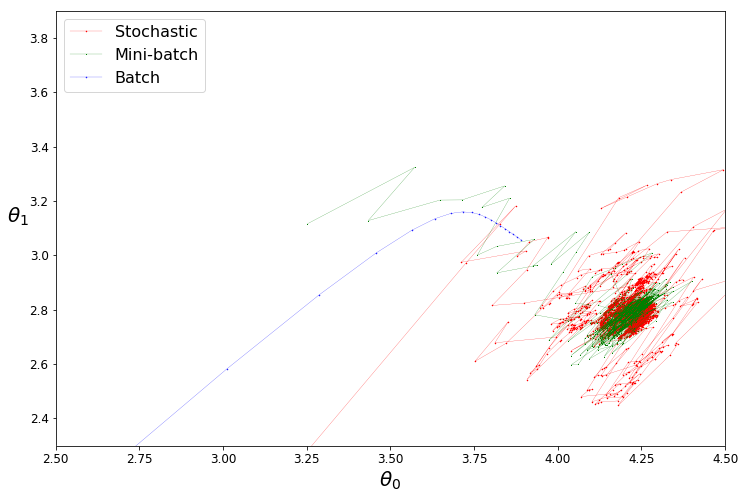

In [16]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(12,8))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=0.2, label="Stochastic", ms=0.5)
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=0.2, label="Mini-batch", ms=0.5)
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=0.2, label="Batch", ms=0.5)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

Let's compare the options:

| Algorith | Large m | Out-of-core support | Large n | Hyper-params | Scaling Required | Scikit-learn | 
|-|
| Normal Equation | Fast| No | Slow | 0 | No | Linear Regression |
| Batch GD | Slow| No | Fast | 2 | Yes | N/A |
| Stochastic GD | Fast| Yes | Fast | >=2 | Yes | SGDRegressor |
| Mini Batch  GD | Fast| Yes | Fast | >=2 | Yes | SGDRegressor |

#### Polynomial Regression

You can use a linear model to fit non-linear data. One simple way is to add powers of each feature as new features, then train a model on this extended feature set. 

Let's look at an example. First, a simple quadratic equation w/ noise:

In [17]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
# Y = 0.5 * x^2 + x + 2 + noise
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

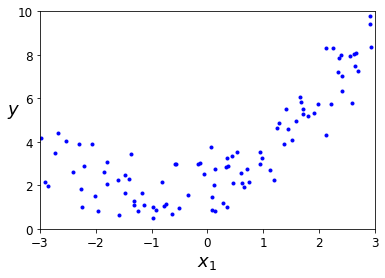

In [18]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

No line will fit this curve. Let's use scikit's *PolynomialFeatures* class to transform our training data, adding the square of each feature in the training set as new features. (Just one feature in this case). 

In [19]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([ 2.38942838])

In [20]:
X_poly[0]

array([ 2.38942838,  5.709368  ])

X_poly now contains the original X, along with the square of X. Now we can fit a linear regression to this extended training data:

In [21]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 1.9735233]), array([[ 0.95038538,  0.52577032]]))

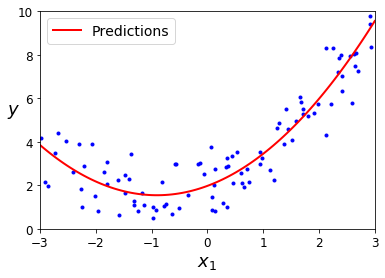

In [22]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

this model predicted y = .95X^2 + 0.52X .+ 1.97, pretty close to the original!

When there are multiple features, Polynomial Regression can find relationship between features. EG, if we did poly-regression with degree 3 and features a and b, it would produce a, a^2, a^3, b, b^2, b^3, ab, ab^2, a^2b.

#### Learning Curves

In general, a high degree polynomial regression will fit data better than simple linear regression. The following compares linear, 2nd degree, and 300 degree polynomial curve to fit data:

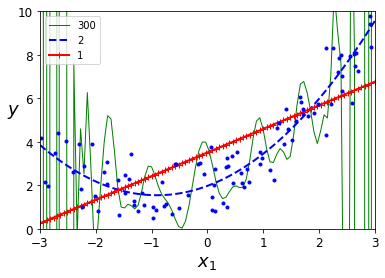

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

The 300 degree is severely overfitting, and the 1 degree is underfitting. Degree = 2 is the best, but of course it is as that was the original function. We don't always know the original degree, so how to choose the best degree for poly regression?

One way is to look at *Learning Curves*. These plot the performance of the model against the training and validation sets, as the size of the training set changes. Here's a function for the plotting:

In [44]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

First let's see how the linear model performs:

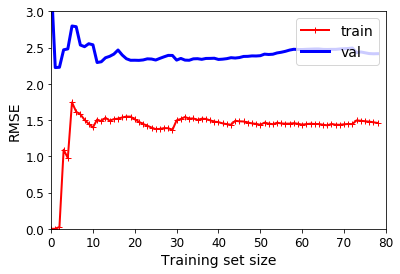

In [45]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
plt.show()       

The model fits the training set perfectly when the size is very small, then the error increases and plateaus quite quickly. The error on the validation set is huge at first, then plateaus quickly as well. These curves are typical of an underfitting model: plateau quickly w/ significant error.

Now, let's try the same thing with a 10th order model:

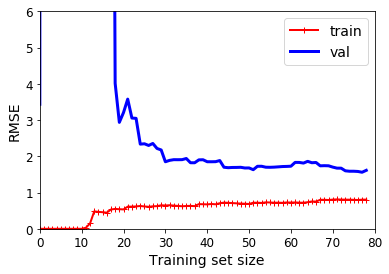

In [46]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 6])           # not shown
plt.show()                        # not shown

compared to the linear model, this performs much better on the training data. Difference between training and validation is quite large, but improves with training set size; a hallmark of overfitting.

#### The Bias/Variance tradeoff

A model's generalization error can be expressed as the sum of three very different errors:

1. Bias: This is due to wrong assumptions, such as that a model is quadratic when it is actually 10th order etc. A high bias model is likely to underfit the data.

2. Variance: The model is excessively sensitive to small variations in the training data. A high-degree model is likely to have high variance, and thus overfit the training data.

3. Irreducible error: Noise in the data. Impossible to reduce without fixing the collection of data; ie. better sensors etc.

Increasing a model's complexity will likely increase variance and reduce bias, whereas reducing complexity will reduce variance but increase bias. Hence, it's a tradeoff.

#### Regularized Linear Models

A good way to reduce overfitting is to regularize a model. Eg on a polynomial model, you can reduce the degrees of the polynomial, or for linear, you can constrain the weights of the model. We will look at Ridge Regression, Lassoo regression, and Elastic Net regression, which implement three separate ways to constrain the weights.

##### Ridge Regression

Ridge Regression is a regularized version of Linear Regression. A regularization term equal to $ \alpha \sum_{i=1}^{n}{{\theta_i}^2}$ is added to the cost function. This forces the model weights to be kept as low as possible ( I guess because otherwise they're getting squared and blowing shit up..)

note: only add this term during training. Once trained, evaluate without the extra term.

The hyperparameter $ \alpha $ controls how heavily regularized the model is. If $ \alpha $=0, it's just linear regression. If $ \alpha $ is large, then all weights end up low, and the model is almost a flat line going through the data's mean.

Here is the Ridge Regression Cost Function

$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \dfrac{1}{2}\sum\limits_{i=1}^{n}{\theta_i}^2
$


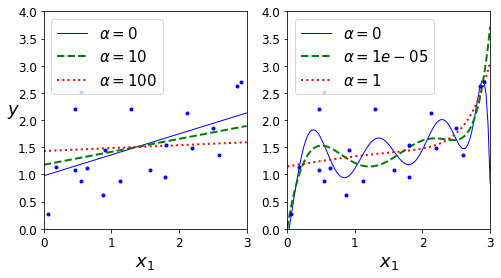

In [47]:
from sklearn.linear_model import Ridge

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

The left chart shows linear regression and the right a polynomial (10th degree) regression respond to changes in $ \alpha $. Increase $ \alpha $ decreases the model's variance and increase bias.

As with linear regression, we can used closed form solution or gradient descent. The pros and cons are the same.

Here's how to perform it using closed-form with scikit:

In [48]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[ 1.55071465]])

And using SGD. The 'penalty' indicates the type of reg., L2 equals Ridge apparently.

In [51]:
sgd_reg = SGDRegressor(n_iter=5, penalty="l2", random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([ 1.13500145])

##### Lasso Regression

Least Absolute Shrinkage and Selection Operator Regression is another version of regularized linear regression, just like Ridge.

An important characteristic of Lasso is that it tends to eliminate weights of the least important features. Ie, it performs feature selection and outputs a sparse model; ie one with few non-zero feature weights.

Here's how to use it in scikit learn:

In [52]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([ 1.53788174])

##### Elastic Net

Elastic Net is a mix between Ridge and Lasso. There is a mix term, r. When r=0, it is equal to ridge, and when it's 1, it's equal to Lasso. 

So when to use regular linear, ridge, lasso, or elastic?

Generally always good to have some regularization, so tend to avoid vanilla Linear Regression. Ridge is usually good, but if you expect that few features are actually relevant, than Elastic or Lasso could be good. In general, elastic preferred over lasso since lasso can behave erratically in some conditions.

Here is an example of elastic net using scikit:

In [53]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([ 1.54333232])

##### Early Stopping

A different way to regularize iterative learning algorithsm such as Gradient Descent is to just stop once the validation error gets small enough. 

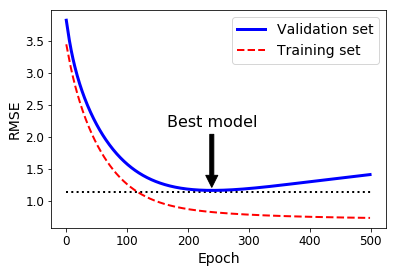

In [56]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(n_iter=1,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

In the above chart, you can see the validation error hits a minimum after about 250 epochs. That would be a good time to stop training, as beyond that the error on validation set starts to increase (due to overfitting).

#### Logistic Regression

Some regression algorithms can be used for classification as well as regression. Logistic Regression (aka Logit Regression) is one example. If the estimated probablity that an example belongs to a class is > 50%, then it likely does, otherwise, it likely doesn't. It is a binary classifier.

##### Estimating Probablities

It's complicated, but basically given an instance, it will produce probability that that instance belongs to a given class. 

##### Decision Boundaries

Let's use iris dataset to illustrate logistic regression.


In [57]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names']

In [58]:
print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

We've loaded the data, now lets fit the model. To start, we'll just try to do a binary classifier on iris-virginica based on petal-width.

In [60]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginica, else 0

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

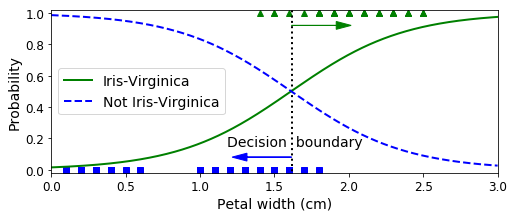

In [62]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

Width petal width above ~1.6, the model would say it's likely to be iris-virginica, below that threshold, it's likely not.

In [63]:
decision_boundary

array([ 1.61561562])

In [64]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

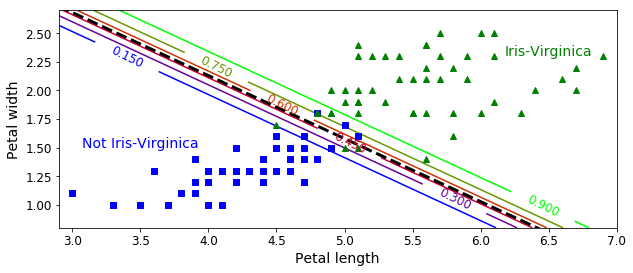

In [65]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

The above figure is the same as the previous, but now looking at petal-width and petal-length.

##### Softmax Regression

Logistic Regression can support multiple classes directly; we don't have to combine multiple binary classifiers (as seen in Chapter 2). This is called *Softmax Regression* or *Multinomial Logistic Regression*. 

Let's train the model using softmax:

In [66]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [67]:
softmax_reg.predict([[5, 2]])

array([2])

In [68]:
softmax_reg.predict_proba([[5, 2]])

array([[  6.33134077e-07,   5.75276067e-02,   9.42471760e-01]])

We can see that it is 95% sure that it is Iris-Virginica (class 2).

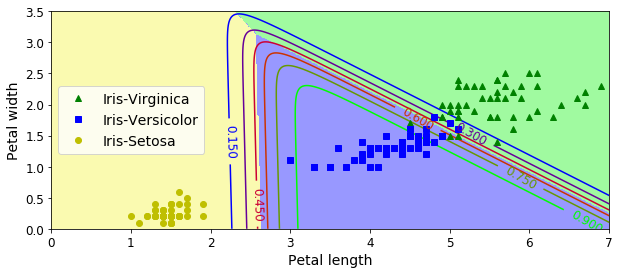

In [75]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

# the 1 is iris-versicolor
zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

We can see the decision boundaries based on width and height for all 3 classes above. The barriers between any 2 classes are linear, and you can see the point (2.5,3) where all are equally likely. The curved lines represent the probability of iris-versicolor (quite high beneath the green line).

## Exercises

**Q1.**: What Linear Regression training algorithm can you use if you have a training set with millions of features? ?

**A1.**:
Stochastic Gradient Descent would be best as it can deal with many features well. You could also use mini-batch, or maybe even batch. The normal equation would not work as the time is takes is exponential with the number of features.

**Q2**: Suppose the features in your training set have very different scales. What algorithms might suffer from this, and how? What can you do about it?

**A2**: All of the gradient descent techniques will suffer if the features have different scales. The scales should be normalized via something like *StandardScalar*.

**Q3**: Can Gradient Descent get stuck in a local minimum when training a Logistic Regression model?

**A3**: Logistic regression cost function is always convex, so gradient descent cannot get stuck in a local minimum.

**Q4**: Do all Gradient Descent algorithms lead to the same model provided you let them run long enough?

**A4**: No, a basic gradient descent could get stuck in a local minimum, whereas a stochastic/batch would not. However, in an optimization where the cost function is convex (linear regression, logistic regression), all algorithms will approach the same global minimum. Stochastic and mini-batch will jump around and never settle, unless you reduce the learning rate over time.

**Q5**: Suppose you use Batch Gradient Descent and you plot the validation error at every epoch. If you notice that the validation error consistently goes up, what is likely going on? How can you fix this?

**A5**: The model is overfitting the data. You could use 'early-stopping' to stop training the model once you have reached a minimum in the validation error. Another possibility is that the learning rate is too high, and the model is bouncing away from the cost function's minimum.

**Q6**: Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?

**A6**: It could just be that the randomly selected batch were outliers and the model doesn't generalize well to them.  Mini batch and SGD will not always improve every iteration; instead, we can wait and see if the model hasn't improved for a while, and then revert to the last best model.

**Q7**: Which Gradient Descent algorithm (among those we discussed) will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?

**A7**: SGD will approach the minimum the fastest; or batch-gd with a small batch size. Only regular Batch GD will converge, but the others can be made to almost converge by gradually reducing the learning rate.

**Q8**: Suppose you are using Polynomial Regression. You plot the learning curves and you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?

**A8**: The large gap would suggest overfitting. You could try to reduce the degree of the regression. You could also try regularizing the model via L1, L2, or elastic-net regularization.

**Q9**: Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter α or reduce it?

**A9**: If they are equal, then that suggests under-fitting, ie. high variance and low bias. $ \alpha $ should be reduced to give the model some more flexibility.

**Q10**: Why would you want to use:

- Ridge Regression instead of plain Linear Regression (i.e., without any regularization)?

- Lasso instead of Ridge Regression?

- Elastic Net instead of Lasso?

**A10**:

- Ridge regression is a good default form of regularization. It's often better than plain Linear Regression as it will help prevent overfitting.

- Lassoo is nice because it tends to eliminate meaningless features, helping to simplify the model. If you suspect that feature reduction is necessary, lasso is a good choice, but if not, prefer ridge.

- Elastic net is often preferred over lasso as it combined lasso and ridge, and lasso alone can produce erratic behavior in certain conditions.

**Q11**: Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime. Should you implement two Logistic Regression classifiers or one Softmax Regression classifier?

**A11**: These are not exclusive classifications, so you should train two logistic classifiers. Softmax is multiclass, not multi-output; ie it cannot produce two separate classifications at once.

**Q12**: see [separate notebook](exercises.ipynb).